# Prevendo Depesas Médicas

### "Exercício realizado durante o curso Data Science Aplicada à Área de Saúde da Data Science Academy"

## 1) Problema de negócio

O custo de despesas médicas tem se tornado um problema cada vez maior, atingindo todo o Sistema de Saúde, principalmente hospitais. 

Pensando nisso, iremos criar um modelo capaz de prever o custo de despesas médicas para uma amostra da população de pacientes de um hospital, considerando o hábito de fumar, idade, sexo, IMC e região. 


## 2) Carrregando os dados

Dicionário de Dados:
    
- idade: idade do paciente

- sexo: sexo do paciente (feminino, masculino)

- IMC: índice de massa corporal, usando a razão entre altura e peso (idealmente 18,5 a 24,9)

- filhos: número de filhos do paciente

- fumante: se fuma ou não

- região: a área residencial do paciente.

- custo_medico_anual: custo médico anual do paciente em uma clínica medica (variável alvo)

In [1]:
# Importando os pacotes que iremos trabalhar
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import matplotlib as m
m.__version__

'3.2.1'

In [3]:
# Carregando o dataset
dataset = pd.read_csv('dados/custos_seguro.csv')

In [4]:
# Visualizando alguns registros
dataset.head() 

,idade,sexo,imc,filhos,fumante,regiao,custo_medico_anual
0,19,feminino,27.90,0,yes,sudeste,16884.92400
1,18,masculino,33.77,1,no,sul,1725.55230
2,28,masculino,33.00,3,no,sul,4449.46200
3,33,masculino,NaN,0,no,nordeste,21984.47061
4,32,masculino,28.88,0,no,nordeste,3866.85520


In [5]:
# Visualizando os tipos de dados
dataset.dtypes

idade                   int64
sexo                   object
imc                   float64
filhos                  int64
fumante                object
regiao                 object
custo_medico_anual    float64
dtype: object

## 3) Data Munging - Preparando dados para análise exploratória

In [6]:
# Visualizando o total de linhas por coluna
dataset.count()

idade                 1338
sexo                  1338
imc                   1325
filhos                1338
fumante               1338
regiao                1338
custo_medico_anual    1338
dtype: int64

In [7]:
# Verifique se há valores ausentes
missing_values = dataset.isnull().sum().sort_values(ascending = False)
missing_values

imc                   13
custo_medico_anual     0
regiao                 0
fumante                0
filhos                 0
sexo                   0
idade                  0
dtype: int64

In [8]:
# Checando percentual de valores missing
missing_values = missing_values[missing_values > 0]/dataset.shape[0] 
print(f'{missing_values * 100} %')

imc    0.971599
dtype: float64 %


### 3.1 - Tratamento de valores missing na coluna IMC

Vamos usar o recurso de imputação, aplicando a média aos valores ausentes na coluna imc

In [10]:
# Função para o Replace das linhas vazias
def impute_media(df):
    return df.fillna(df.mean())

In [11]:
# Removendo valores missing
dataset.imc = dataset['imc'].transform(impute_media)

In [12]:
# Verifique se há valores ausentes
missing_values = dataset.isnull().sum().sort_values(ascending = False)
missing_values = missing_values[missing_values > 0]/dataset.shape[0] 
print(f'{missing_values *100} %')

Series([], dtype: float64) %


### 3.2 - Convertendo variáveis categóricas para o tipo numérico

In [13]:
# Convertendo todas as variáveis para o tipo inteiro a fim de calcular as correlações
from sklearn.preprocessing import LabelEncoder

dataset_transformado = dataset.apply(LabelEncoder().fit_transform)

In [14]:
# Visualizando os tipos de dados
dataset_transformado.dtypes

idade                 int32
sexo                  int32
imc                   int32
filhos                int32
fumante               int32
regiao                int32
custo_medico_anual    int32
dtype: object

In [15]:
dataset_transformado.head()

,idade,sexo,imc,filhos,fumante,regiao,custo_medico_anual
0,1,0,197,0,1,2,1005
1,0,1,351,1,0,3,57
2,10,1,332,3,0,3,306
3,15,1,272,0,0,0,1097
4,14,1,223,0,0,0,254


## 4) Análise Exploratória

Nessa etapa, iremos fazer alguns questionamentos para verificar relação entre algumas variáveis preditores com a variável target.

### 4.1 - Quais variáveis tem maior correlação com o custo_medico_anual?

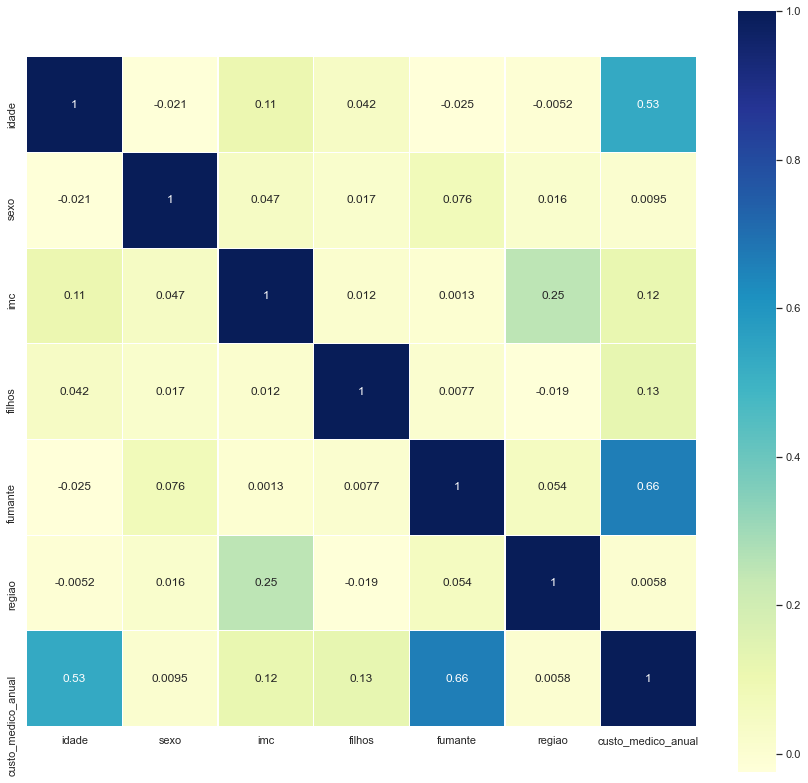

In [16]:
# Definindo propriedades do Seaborn
sns.set(color_codes = True)

# Definindo área de platagem
plt.figure(figsize = (15, 14))

# Criando o heatmap
sns.heatmap(dataset_transformado.astype(float).corr(), 
            linewidths = 0.1, 
            square = True, 
            linecolor = 'white', 
            annot = True,
            cmap = "YlGnBu")
plt.show()

Pela tabela de correlação, temos que as variáveis fumante e idade são as que tem maior correlação com o custo médico anual.

### 4.2 Entre fumantes e não fumantes, qual grupo tem maior custo_medico_anual?

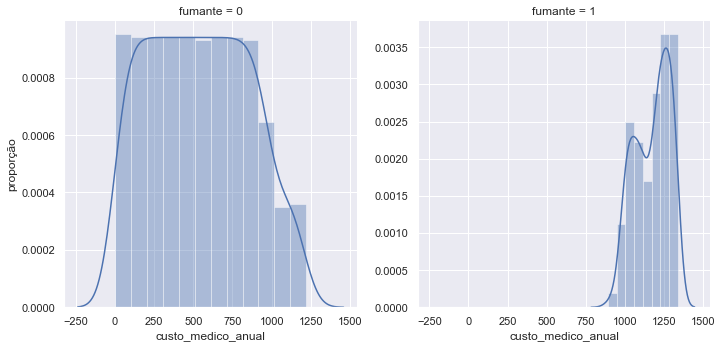

In [17]:
# Solução com Seaborn usando um FacetGrid
grafico = sns.FacetGrid(dataset_transformado, col = "fumante", height = 5, sharey = False, sharex = True)
grafico.map(sns.distplot, "custo_medico_anual", color = 'b');
grafico.set_axis_labels("custo_medico_anual", "proporção");

Pela análise gráfica, podemos inferir que o fato de ser fumante tem relevância considerável nos custos médicos.

### 4.3 - Qual faixa etária apresenta maior custo_medico_anual?

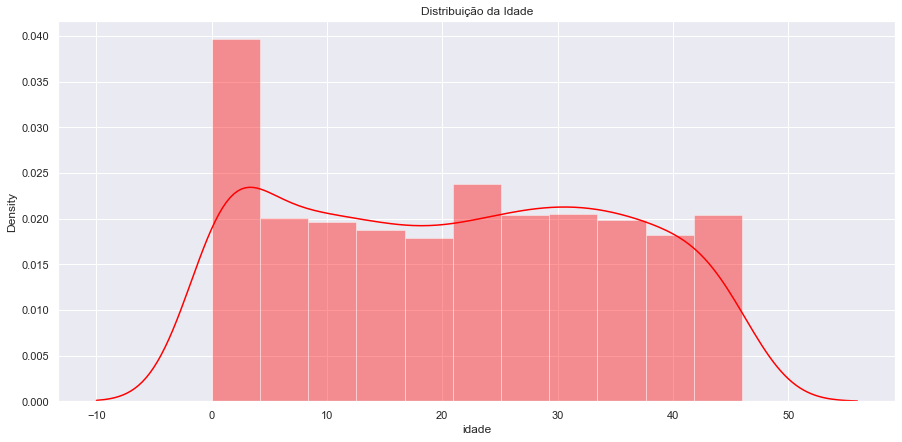

In [18]:
# Solução gráfica com Seaborn
plt.figure(figsize = (15,7))
plt.title("Distribuição da Idade")
ax = sns.distplot(dataset_transformado["idade"], color = 'red')

A faixa etária de até 0 a 1 ano é a que requer maior cursto médio anual

## 5) Modelagem preditiva - Machine Learning

### 5.1 - Pré processamento dos dados

In [22]:
# Dados após a fase de pré-processamento nos itens anteriores
dataset.head()

,idade,sexo,imc,filhos,fumante,regiao,custo_medico_anual
0,19,feminino,27.900000,0,yes,sudeste,16884.92400
1,18,masculino,33.770000,1,no,sul,1725.55230
2,28,masculino,33.000000,3,no,sul,4449.46200
3,33,masculino,30.693019,0,no,nordeste,21984.47061
4,32,masculino,28.880000,0,no,nordeste,3866.85520


In [23]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   idade               1338 non-null   int64  
 1   sexo                1338 non-null   object 
 2   imc                 1338 non-null   float64
 3   filhos              1338 non-null   int64  
 4   fumante             1338 non-null   object 
 5   regiao              1338 non-null   object 
 6   custo_medico_anual  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 57.6+ KB


Convertendo variáveis categóricas para representações numéricas com Label Encoding

In [24]:
# Prepara as variáveis dummy (converte variáveis categóricas para representações numéricas com Label Encoding)
dataset = pd.get_dummies(dataset)
dataset.head()

,idade,imc,filhos,custo_medico_anual,sexo_feminino,sexo_masculino,fumante_no,fumante_yes,regiao_nordeste,regiao_norte,regiao_sudeste,regiao_sul
0,19,27.900000,0,16884.92400,1,0,0,1,0,0,1,0
1,18,33.770000,1,1725.55230,0,1,1,0,0,0,0,1
2,28,33.000000,3,4449.46200,0,1,1,0,0,0,0,1
3,33,30.693019,0,21984.47061,0,1,1,0,1,0,0,0
4,32,28.880000,0,3866.85520,0,1,1,0,1,0,0,0


In [25]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   idade               1338 non-null   int64  
 1   imc                 1338 non-null   float64
 2   filhos              1338 non-null   int64  
 3   custo_medico_anual  1338 non-null   float64
 4   sexo_feminino       1338 non-null   uint8  
 5   sexo_masculino      1338 non-null   uint8  
 6   fumante_no          1338 non-null   uint8  
 7   fumante_yes         1338 non-null   uint8  
 8   regiao_nordeste     1338 non-null   uint8  
 9   regiao_norte        1338 non-null   uint8  
 10  regiao_sudeste      1338 non-null   uint8  
 11  regiao_sul          1338 non-null   uint8  
dtypes: float64(2), int64(2), uint8(8)
memory usage: 52.3 KB


### 5.2 - Divisão dos dados em treino e teste

In [26]:
X = dataset.drop(['custo_medico_anual'], axis = 1)

In [27]:
y = dataset['custo_medico_anual']

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [29]:
import sklearn as sk
sk.__version__

'0.22.2'

### 5.3 - Criando Modelo de Regressão Linear

Como queremos prever um valor numérico "custo médico", usaremos o modelo de Regressão Linear

In [30]:
# Cria a primeira versão do modelo de regressão linear

# Imports
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Cria o modelo e treina com os dados de teste
lr = LinearRegression().fit(X_train, y_train)

# Previsões nos dados de treino
lr_train_pred = lr.predict(X_train)

# Previsões nos dados de teste
lr_test_pred = lr.predict(X_test)

In [31]:
# Calcula as métricas
lr_train_mse = mean_squared_error(y_train, lr_train_pred)
lr_test_mse = mean_squared_error(y_test, lr_test_pred)

# Imprime o MSE (Mean Squared Error)
print('MSE nos dados de treino: {:.5}, MSE nos dados de teste: {:.5}'.format(lr_train_mse, lr_test_mse))

# Imprime o RMSE (Root Mean Squared Error)
print('RMSE nos dados de treino: {:.5}, RMSE nos dados de teste: {:.5}'.format(
    np.sqrt(np.absolute(lr_train_mse)), 
    np.sqrt(np.absolute(lr_train_mse))))
  
# Coeficiente R2
print('R2 nos dados de treino: {:.5}, R2 nos dados de teste: {:.5}'.format(
    r2_score(y_train, lr_train_pred),
    r2_score(y_test, lr_test_pred)))

MSE nos dados de treino: 3.6915e+07, MSE nos dados de teste: 3.2604e+07
RMSE nos dados de treino: 6075.8, RMSE nos dados de teste: 6075.8
R2 nos dados de treino: 0.74968, R2 nos dados de teste: 0.76367


Pela análise do coeficiente R2, nosso modelo apresentou 74% de precisão em dados de treino e 76% em dados de teste.

### 5.4 - Criando modelo Random Forest (método Ensemble)

In [32]:
# Import
from sklearn.ensemble import RandomForestRegressor

# Cria e treina o modelo
rfr = RandomForestRegressor(n_estimators = 50).fit(X_train, y_train)

# Previsões em treino e teste
rfr_train_pred = rfr.predict(X_train)
rfr_test_pred = rfr.predict(X_test)

In [33]:
# Calcula as métricas em treino e meste
rfr_train_mse = mean_squared_error(y_train,rfr_train_pred)
rfr_test_mse = mean_squared_error(y_test,rfr_test_pred)

# Imprime o MSE (Mean Squared Error)
print('MSE nos dados de treino: {:.5}, MSE nos dados de teste: {:.5}'.format(rfr_train_mse, rfr_test_mse))

# Imprime o RMSE (Root Mean Squared Error)
print('RMSE nos dados de treino: {:.5}, RMSE nos dados de teste: {:.5}'.format(
    np.sqrt(np.absolute(rfr_train_mse)), 
    np.sqrt(np.absolute(rfr_train_mse))))
    
# Coeficiente R2
print('R2 nos dados de treino: {:.5}, R2 nos dados de teste: {:.5}'.format(
    r2_score(y_train, rfr_train_pred),
    r2_score(y_test, rfr_test_pred)))

MSE nos dados de treino: 3.5974e+06, MSE nos dados de teste: 2.5187e+07
RMSE nos dados de treino: 1896.7, RMSE nos dados de teste: 1896.7
R2 nos dados de treino: 0.97561, R2 nos dados de teste: 0.81743


Esta é uma previsão decente, podemos assumir que o RandomForest apresenta um melhor resultado com uma pontuação R2 de 97% nos dados de treinamento e 82% nos dados de teste. Ele também tem o menor valor RMSE.

# Fim